<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [16]:
import os
import sys
import datetime
import time
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List

from utils import mind as dataset

%load_ext autoreload
%autoreload 2

if 'src' not in sys.path:
    sys.path.append('src')

from metrecs.utils import (
    harmonic_number,
    normalized_scaled_harmonic_number_series,
    compute_normalized_distribution_multiple_categories,
    opt_merge_max_mappings,
    avoid_distribution_misspecification,
    user_level_RADio_multicategorical
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
def get_classic_calibration(
    pred_preselection_df: pd.DataFrame,
    articles_df: pd.DataFrame,
    behaviors_presel_df: pd.DataFrame,
    cat_column: str,
    top_at: int,
) -> pd.DataFrame:
    df_cat = dataset.get_cat(
        pred_preselection_df,
        articles_df,
        "pred_slice_id",
        cat_column,
        top_at,
        slice_col=True,
    )

    df_cat_history = dataset.get_cat(
        behaviors_presel_df[["index", "user", "behavior_array"]],
        articles_df,
        "behavior_array",
        cat_column,
        top_at,
        slice_col=False,
    )
    df_cat_history = df_cat_history.rename(
        columns={
            "sorted_cat_list": "history_cat_list",
            "sorted_newsid_list": "history_newsid_list",
        }
    )

    df_calibration = df_cat.merge(df_cat_history, on=["index", "user"], how="inner")

    df_calibration["calibration"] = df_calibration.apply(
        lambda row: user_level_RADio_multicategorical(
            row["sorted_cat_list"],
            row["history_cat_list"],
            list(normalized_scaled_harmonic_number_series(len(row["sorted_cat_list"]))),
        ),
        axis=1,
    )
    return df_calibration


def get_classic_representation(
    pred_preselection_df: pd.DataFrame,
    articles_df: pd.DataFrame,
    behaviors_presel_df: pd.DataFrame,
    cat_column: str,
    top_at: int,
) -> pd.DataFrame:
    df_cat = dataset.get_cat(
        pred_preselection_df,
        articles_df,
        "pred_slice_id",
        cat_column,
        top_at,
        slice_col=True,
    )

    df_cat_pool = dataset.get_cat(
        behaviors_presel_df[["index", "user", "pool_array"]],
        articles_df,
        "pool_array",
        cat_column,
        top_at,
        slice_col=False,
    )
    df_cat_pool = df_cat_pool.rename(
        columns={
            "sorted_cat_list": "pool_cat_list",
            "sorted_newsid_list": "pool_newsid_list",
        }
    )

    df_representation = df_cat.merge(df_cat_pool, on=["index", "user"], how="inner")

    df_representation["representation"] = df_representation.apply(
        lambda row: user_level_RADio_multicategorical(
            row["sorted_cat_list"],
            row["pool_cat_list"],
            list(normalized_scaled_harmonic_number_series(len(row["sorted_cat_list"]))),
        ),
        axis=1,
    )

    return df_representation


def get_classic_fragmentation(
    pred_preselection_df: pd.DataFrame,
    articles_df: pd.DataFrame,
    cat_column: str,
    top_at: int,
    sample_size: float = 0.05,
) -> pd.DataFrame:
    df_cat = dataset.get_cat(
        pred_preselection_df,
        articles_df,
        "pred_slice_id",
        cat_column,
        top_at,
        slice_col=True,
    )
    df_cat2 = df_cat.sample(frac=0.01).rename(
        columns={
            "index": "other_index",
            "user": "other_user",
            "sorted_cat_list": "rec_cat_list",
            "sorted_newsid_list": "rec_newsid",
            "algo": "other_algo",
        }
    )
    df_cat["key"] = 0
    df_cat2["key"] = 0

    df_cat_cat = df_cat.merge(df_cat2, on="key", how="outer")
    df_cat_cat = df_cat_cat.drop(["key"], axis=1)
    df_cat_cat = df_cat_cat[df_cat_cat["index"] != df_cat_cat["other_index"]]

    df_cat_cat["fragmentation_detail"] = df_cat_cat.apply(
        lambda row: user_level_RADio_multicategorical(
            row["sorted_cat_list"],
            row["rec_cat_list"],
            list(normalized_scaled_harmonic_number_series(len(row["sorted_cat_list"]))),
            list(normalized_scaled_harmonic_number_series(len(row["rec_cat_list"]))),
        ),
        axis=1,
    )
    df_fragmentation = df_cat_cat.groupby(["index", "user", "algo"]).agg(
        {"fragmentation_detail": "mean"}
    )
    df_fragmentation = df_fragmentation.rename(
        columns={"fragmentation_detail": "fragmentation"}
    ).reset_index()
    return df_fragmentation


In [21]:
def read_recommendations_and_calculate_metrics(
        articles_df: pd.DataFrame,
        behaviors_presel_df: pd.DataFrame,
        suffix: str,
        algos: List[str],
        top_at: int=10,
        NR_BINS: int=200,
        path_prediction: str = 'examples/MIND/recommendations/'
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df_calibration_all = pd.DataFrame()
    df_representation_all = pd.DataFrame()
    df_fragmentation_all = pd.DataFrame()

    for algo in algos:
        print (f'Processing algorithm {algo}')
        PATH_PRED = path_prediction+algo+'_pred_'+suffix+'.json'
        pred_df, pred_preselection_df = dataset.read_predictions(
            PATH_PRED, behaviors_presel_df, top_k = top_at, algo = algo
        )

        df_calibration = get_classic_calibration(
            pred_preselection_df, articles_df, behaviors_presel_df, 'cat_as_list', top_at
        )
        df_calibration = df_calibration[['index','user','calibration','algo']]

        df_calibration_all = pd.concat([df_calibration_all, df_calibration], ignore_index=True)

        df_representation = get_classic_representation(pred_preselection_df, articles_df, behaviors_presel_df, 'cat_subcat', top_at)
        df_representation = df_representation[['index','user','representation','algo']]
        df_representation_all = pd.concat([df_representation_all, df_representation], ignore_index=True)

        df_fragmentation = get_classic_fragmentation(pred_preselection_df, articles_df, 'cat_subcat', top_at, sample_size=0.02)
        df_fragmentation_all = pd.concat([df_fragmentation_all, df_fragmentation], ignore_index=True)

    df_calibration_all['calibration_bin'] = df_calibration_all.apply(lambda row: round(row['calibration']*NR_BINS,0)/NR_BINS, axis=1)

    df_representation_all['representation_bin'] = df_representation_all.apply(lambda row: round(row['representation']*NR_BINS,0)/NR_BINS, axis=1)

    if df_fragmentation_all.shape[0] > 0:
        df_fragmentation_all['fragmentation_bin'] = df_fragmentation_all.apply(lambda row: round(row['fragmentation']*NR_BINS,0)/NR_BINS, axis=1)

    return (
        df_calibration_all,
        df_representation_all,
        df_fragmentation_all
    )

In [19]:
SUFFIX = 'small'
PATH_BEHAVIOURS = 'examples/MIND/behaviors_' + SUFFIX + '.tsv'
PATH_ARTICLES = 'examples/MIND/articles_large_narrow.json'

articles_df = dataset.read_articles(path=PATH_ARTICLES)
behaviors_presel_df = dataset.read_behavior(path=PATH_BEHAVIOURS)

Nr of unique articles 68392


In [24]:
algos = ['pop', 'lstur', 'pop', 'naml', 'npa', 'nrms']

In [25]:
# This will take some time due to fragmentation (around 35 min)
PATH_PRED = 'examples/MIND/recommendations/'
df_calibration_all, df_representation_all, df_fragmentation_all = read_recommendations_and_calculate_metrics(
    articles_df,
    behaviors_presel_df,
    sufix = SUFFIX,
    algos = algos,
    top_at =
    10,
    NR_BINS = 200,
    path_prediction=PATH_PRED
)

pop
lstur
pop
naml
npa
nrms


In [35]:
df_calibration_all.to_parquet('./examples/results/MIND/calibration.parquet')
df_representation_all.to_parquet('./examples/results/MIND/representation.parquet')
df_fragmentation_all.to_parquet('./examples/results/MIND/fragmentation.parquet')

In [36]:
calibration_agg_df = df_calibration_all.groupby(['algo', 'calibration_bin']).agg({'index':'count'})
calibration_agg_df = calibration_agg_df.rename(columns={'index':'count'}).reset_index()

representation_agg_df = df_representation_all.groupby(['algo', 'representation_bin']).agg({'index':'count'})
representation_agg_df = representation_agg_df.rename(columns={'index':'count'}).reset_index()

fragmentation_agg_df = df_fragmentation_all.groupby(['algo', 'fragmentation_bin']).agg({'index':'count'})
fragmentation_agg_df = fragmentation_agg_df.rename(columns={'index':'count'}).reset_index()

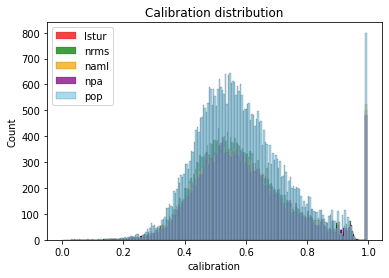

In [27]:
df = df_calibration_all

# Plot the histogram tahanks to the histplot function
sns.histplot(data=df.loc[(df["algo"] == "lstur"), ["calibration"]], bins=200, x="calibration", color="red", label="lstur", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "nrms"), ["calibration"]], bins=200, x="calibration", color="green", label="nrms", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "naml"), ["calibration"]], bins=200, x="calibration", color="orange", label="naml", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "npa"), ["calibration"]], bins=200, x="calibration", color="purple", label="npa", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "pop"), ["calibration"]], bins=200, x="calibration", color="skyblue", label="pop", kde=False)

plt.title("Calibration distribution")
  
plt.legend(['lstur', 'nrms', 'naml', 'npa', 'pop'])
  
plt.show()

In [28]:
calibration_mean_std = df_calibration_all.groupby('algo').agg({'calibration':'mean'}).merge(
                        df_calibration_all.groupby('algo').agg({'calibration':'std'}), on='algo')
calibration_mean_std = calibration_mean_std.rename(columns={'calibration_x':'calibration_mean', 
                                                            'calibration_y':'calibration_std'}).reset_index()
calibration_mean_std

,algo,calibration_mean,calibration_std
0,lstur,0.584647,0.146389
1,naml,0.584609,0.147834
2,npa,0.585289,0.146212
3,nrms,0.580380,0.145948
4,pop,0.583852,0.147156


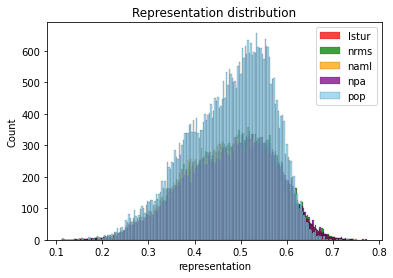

In [29]:
df = df_representation_all

sns.histplot(data=df.loc[(df["algo"] == "lstur"), ["representation"]], bins=200, x="representation", color="red", label="lstur", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "nrms"), ["representation"]], bins=200, x="representation", color="green", label="nrms", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "naml"), ["representation"]], bins=200, x="representation", color="orange", label="naml", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "npa"), ["representation"]], bins=200, x="representation", color="purple", label="npa", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "pop"), ["representation"]], bins=200, x="representation", color="skyblue", label="pop", kde=False)

plt.title("Representation distribution")
  
plt.legend(['lstur', 'nrms', 'naml', 'npa', 'pop'])
  
plt.show()

In [30]:
representation_mean_std = df_representation_all.groupby('algo').agg({'representation':'mean'}).merge(
                        df_representation_all.groupby('algo').agg({'representation':'std'}), on='algo')
representation_mean_std = representation_mean_std.rename(columns={'representation_x':'representation_mean', 
                                                            'representation_y':'representation_std'}).reset_index()
representation_mean_std

,algo,representation_mean,representation_std
0,lstur,0.471451,0.095339
1,naml,0.468553,0.096186
2,npa,0.476683,0.097911
3,nrms,0.476347,0.096935
4,pop,0.476303,0.090945


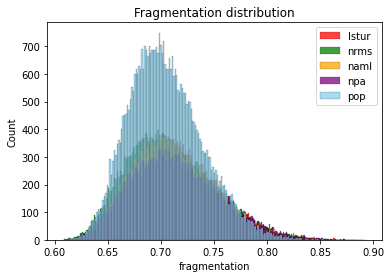

In [31]:
df = df_fragmentation_all
  
sns.histplot(data=df.loc[(df["algo"] == "lstur"), ["fragmentation"]], bins=200, x="fragmentation", color="red", label="lstur", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "nrms"), ["fragmentation"]], bins=200, x="fragmentation", color="green", label="nrms", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "naml"), ["fragmentation"]], bins=200, x="fragmentation", color="orange", label="naml", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "npa"), ["fragmentation"]], bins=200, x="fragmentation", color="purple", label="npa", kde=False)
sns.histplot(data=df.loc[(df["algo"] == "pop"), ["fragmentation"]], bins=200, x="fragmentation", color="skyblue", label="pop", kde=False)

plt.title("Fragmentation distribution")
  
plt.legend(['lstur', 'nrms', 'naml', 'npa', 'pop'])
  
plt.show()

In [32]:
fragmentation_mean_std = df_fragmentation_all.groupby('algo').agg({'fragmentation':'mean'}).merge(
                        df_fragmentation_all.groupby('algo').agg({'fragmentation':'std'}), on='algo')
fragmentation_mean_std = fragmentation_mean_std.rename(columns={'fragmentation_x':'fragmentation_mean', 
                                                            'fragmentation_y':'fragmentation_std'}).reset_index()
fragmentation_mean_std

,algo,fragmentation_mean,fragmentation_std
0,lstur,0.714545,0.038469
1,naml,0.712892,0.038955
2,npa,0.713956,0.041249
3,nrms,0.709370,0.041287
4,pop,0.704661,0.034769
